## VERSIONE OTTIMIZZATA


Testing w=3
 • proposed: 0.0011 sec
 • sauvola: 0.0005 sec
 • niblack: 0.0004 sec
 • bernsen: 0.0004 sec
 • otsu: 0.0014 sec

Testing w=5
 • proposed: 0.0003 sec
 • sauvola: 0.0006 sec
 • niblack: 0.0004 sec
 • bernsen: 0.0003 sec
 • otsu: 0.0000 sec

Testing w=7
 • proposed: 0.0003 sec
 • sauvola: 0.0005 sec
 • niblack: 0.0005 sec
 • bernsen: 0.0002 sec
 • otsu: 0.0000 sec

Testing w=9
 • proposed: 0.0004 sec
 • sauvola: 0.0006 sec
 • niblack: 0.0005 sec
 • bernsen: 0.0002 sec
 • otsu: 0.0000 sec

Testing w=11
 • proposed: 0.0003 sec
 • sauvola: 0.0005 sec
 • niblack: 0.0006 sec
 • bernsen: 0.0002 sec
 • otsu: 0.0000 sec

Testing w=13
 • proposed: 0.0004 sec
 • sauvola: 0.0007 sec
 • niblack: 0.0005 sec
 • bernsen: 0.0002 sec
 • otsu: 0.0000 sec

Testing w=15
 • proposed: 0.0003 sec
 • sauvola: 0.0006 sec
 • niblack: 0.0007 sec
 • bernsen: 0.0002 sec
 • otsu: 0.0000 sec

Testing w=17
 • proposed: 0.0003 sec
 • sauvola: 0.0005 sec
 • niblack: 0.0005 sec
 • bernsen: 0.0002 sec
 • otsu:

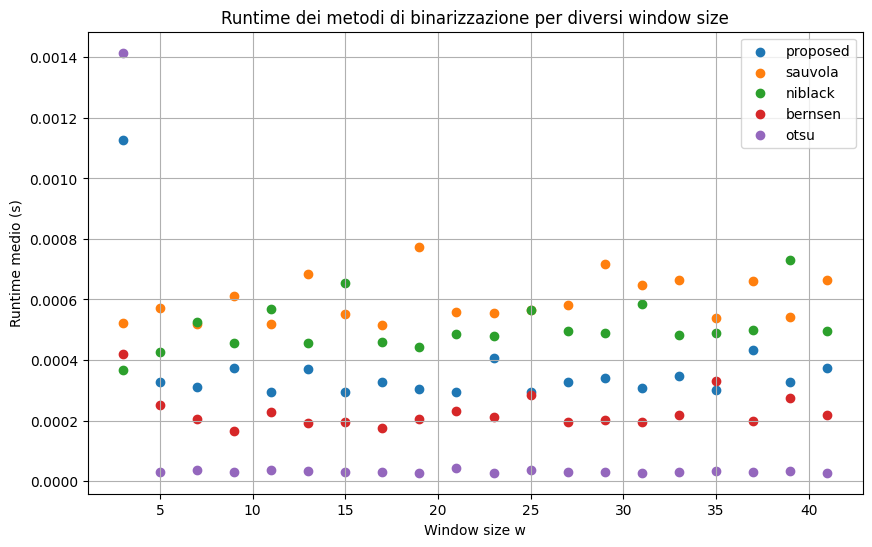

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time


# ============================================================
# LOADING / SAVING
# ============================================================

def load_txt_image(path):
    img = np.loadtxt(path, dtype=float)
    if img.max() <= 1:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    return img

def save_txt_image(path, img):
    np.savetxt(path, img, fmt="%d")


# ============================================================
# LOCAL MEAN AND STD WITH OPENCV
# ============================================================

def local_mean(I, w):
    return cv2.boxFilter(I.astype(np.float64), -1, (w, w), normalize=True)

def local_std(I, w):
    I = I.astype(np.float64)
    mean = cv2.boxFilter(I, -1, (w, w), normalize=True)
    mean2 = cv2.boxFilter(I * I, -1, (w, w), normalize=True)
    var = mean2 - mean * mean
    var[var < 0] = 0
    return mean, np.sqrt(var)


# ============================================================
# PROPOSED METHOD (2011)
# ============================================================

def binarize_proposed(I, w=15, k=0.06):
    I_f = I.astype(np.float64)

    mean = local_mean(I_f, w)
    dev = I_f - mean

    eps = 1e-12
    T = mean * (1 + k * (dev / (1 - dev + eps)))
    return (I_f > T).astype(np.uint8)


# ============================================================
# SAUVOLA
# ============================================================

def binarize_sauvola(I, w=15, k=0.34, R=128):
    I_f = I.astype(np.float64)

    mean, std = local_std(I_f, w)
    T = mean * (1 + k * (std / R - 1))
    return (I_f > T).astype(np.uint8)


# ============================================================
# NIBLACK
# ============================================================

def binarize_niblack(I, w=15, k=-0.2):
    I_f = I.astype(np.float64)

    mean, std = local_std(I_f, w)
    T = mean + k * std
    return (I_f > T).astype(np.uint8)


# ============================================================
# BERNSEN (OPEN-CV)
# ============================================================

def binarize_bernsen(I, w=31, contrast_threshold=15):
    kernel = np.ones((w, w), np.uint8)

    Imax = cv2.dilate(I, kernel)
    Imin = cv2.erode(I, kernel)

    C = Imax - Imin
    T = (Imax + Imin) / 2

    B = (I > T).astype(np.uint8)

    # low contrast
    global_mean = I.mean()
    mask_low = C < contrast_threshold
    B[mask_low] = (I[mask_low] > global_mean).astype(np.uint8)

    return B


# ============================================================
# OTSU
# ============================================================

def binarize_otsu(I):
    _, B = cv2.threshold(I, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return B.astype(np.uint8)


# ============================================================
# BENCHMARK + SCATTER PLOT
# ============================================================

if __name__ == "__main__":

    # ============================
    # USER PARAMETERS
    # ============================
    input_path = "input/blobs.txt"
    window_sizes = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41]
    num_runs = 5

    methods = {
        "proposed": binarize_proposed,
        "sauvola": binarize_sauvola,
        "niblack": binarize_niblack,
        "bernsen": binarize_bernsen,
        "otsu": binarize_otsu
    }

    I = load_txt_image(input_path)

    runtimes = {name: [] for name in methods}

    # ============================
    # BENCHMARK
    # ============================

    for w in window_sizes:
        print(f"\nTesting w={w}")

        for name, func in methods.items():
            t_list = []

            for _ in range(num_runs):
                start = time.time()

                if name == "otsu":
                    func(I)
                else:
                    func(I, w=w)

                t_list.append(time.time() - start)

            runtimes[name].append(np.mean(t_list))
            print(f" • {name}: {runtimes[name][-1]:.4f} sec")


    # ============================
    # SCATTER PLOT
    # ============================

    plt.figure(figsize=(10,6))
    for name in methods:
        plt.scatter(window_sizes, runtimes[name], label=name)

    plt.title("Runtime dei metodi di binarizzazione per diversi window size")
    plt.xlabel("Window size w")
    plt.ylabel("Runtime medio (s)")
    plt.legend()
    plt.grid(True)
    plt.show()


## VERSIONE NAIVE


=== w = 3 ===
Naive sauvola: 1.0797s
Naive niblack: 0.9241s
Naive bernsen: 1.1894s
Naive proposed_naive: 0.4822s
Fast proposed_fast: 0.0007s
Fast otsu: 0.0000s

=== w = 5 ===
Naive sauvola: 1.4290s
Naive niblack: 1.3640s
Naive bernsen: 0.6380s
Naive proposed_naive: 0.4465s
Fast proposed_fast: 0.0007s
Fast otsu: 0.0000s

=== w = 7 ===
Naive sauvola: 1.4032s
Naive niblack: 1.3246s
Naive bernsen: 1.4456s
Naive proposed_naive: 0.4523s
Fast proposed_fast: 0.0007s
Fast otsu: 0.0001s

=== w = 9 ===
Naive sauvola: 1.3414s
Naive niblack: 1.3537s
Naive bernsen: 0.4370s
Naive proposed_naive: 0.4534s
Fast proposed_fast: 0.0006s
Fast otsu: 0.0000s

=== w = 11 ===
Naive sauvola: 1.3547s
Naive niblack: 1.3668s
Naive bernsen: 0.5208s
Naive proposed_naive: 0.5012s
Fast proposed_fast: 0.0008s
Fast otsu: 0.0000s

=== w = 13 ===
Naive sauvola: 1.6758s
Naive niblack: 2.3571s
Naive bernsen: 0.4238s
Naive proposed_naive: 0.4682s
Fast proposed_fast: 0.0006s
Fast otsu: 0.0000s

=== w = 15 ===
Naive sauvola: 1

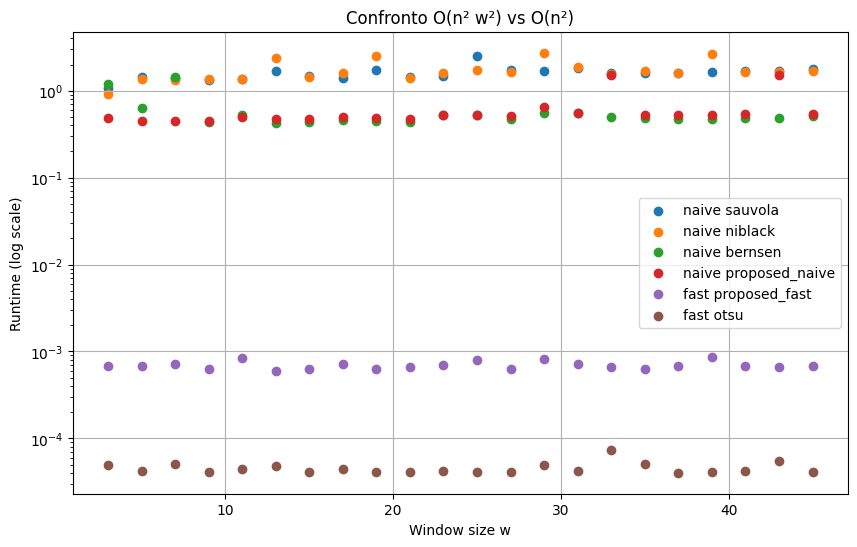

In [ ]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

# ============================================================
# LOADING
# ============================================================

def load_txt_image(path):
    img = np.loadtxt(path, dtype=float)
    if img.max() <= 1:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    return img


# ============================================================
# NAIVE LOCAL METHODS  (O(n^2 w^2))
# ============================================================

def naive_local_mean(I, x, y, w):
    d = w//2
    x1 = max(0, x-d)
    x2 = min(I.shape[0], x+d+1)
    y1 = max(0, y-d)
    y2 = min(I.shape[1], y+d+1)
    region = I[x1:x2, y1:y2]
    return np.mean(region), np.std(region)


def binarize_sauvola_naive(I, w=15, k=0.34, R=128):
    n, m = I.shape
    B = np.zeros_like(I)
    for x in range(n):
        for y in range(m):
            mean, std = naive_local_mean(I, x, y, w)
            T = mean * (1 + k * (std/R - 1))
            B[x,y] = 1 if I[x,y] > T else 0
    return B


def binarize_niblack_naive(I, w=15, k=-0.2):
    n, m = I.shape
    B = np.zeros_like(I)
    for x in range(n):
        for y in range(m):
            mean, std = naive_local_mean(I, x, y, w)
            T = mean + k*std
            B[x,y] = 1 if I[x,y] > T else 0
    return B


def binarize_bernsen_naive(I, w=31, contrast_threshold=15):
    n, m = I.shape
    B = np.zeros_like(I)
    for x in range(n):
        for y in range(m):
            d = w//2
            x1 = max(0, x-d)
            x2 = min(I.shape[0], x+d+1)
            y1 = max(0, y-d)
            y2 = min(I.shape[1], y+d+1)
            region = I[x1:x2, y1:y2]

            Imax = region.max()
            Imin = region.min()
            C = Imax - Imin

            if C < contrast_threshold:
                B[x,y] = 1 if I[x,y] > I.mean() else 0
            else:
                T = (int(Imax) + int(Imin))/2
                B[x,y] = 1 if I[x,y] > T else 0
    return B


def binarize_proposed_naive(I, w=15, k=0.06):
    n, m = I.shape
    B = np.zeros_like(I)
    for x in range(n):
        for y in range(m):
            d = w//2
            x1 = max(0, x-d)
            x2 = min(I.shape[0], x+d+1)
            y1 = max(0, y-d)
            y2 = min(I.shape[1], y+d+1)
            region = I[x1:x2, y1:y2]

            mean = np.mean(region)
            dev = I[x,y] - mean
            T = mean * (1 + k*(dev/(1-dev+1e-12)))

            B[x,y] = 1 if I[x,y] > T else 0
    return B


# ============================================================
# FAST METHODS  (O(n^2))
# ============================================================

def local_mean(I, w):
    return cv2.boxFilter(I.astype(np.float64), -1, (w,w), normalize=True)

def local_std(I, w):
    I = I.astype(np.float64)
    mean = cv2.boxFilter(I, -1, (w,w), normalize=True)
    mean2 = cv2.boxFilter(I*I, -1, (w,w), normalize=True)
    var = mean2 - mean*mean
    var[var < 0] = 0
    return mean, np.sqrt(var)


def binarize_proposed_fast(I, w=15, k=0.06):
    I_f = I.astype(np.float64)
    mean = local_mean(I_f, w)
    dev = I_f - mean
    T = mean * (1 + k*(dev/(1-dev+1e-12)))
    return (I_f > T).astype(np.uint8)


def binarize_otsu(I, w):
    _, B = cv2.threshold(I, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return B


# ============================================================
# BENCHMARK
# ============================================================

def benchmark(I, window_sizes, naive_methods, fast_methods, num_runs=3):

    naive_times = {name: [] for name in naive_methods}
    fast_times  = {name: [] for name in fast_methods}

    for w in window_sizes:
        print(f"\n=== w = {w} ===")

        for name, func in naive_methods.items():
            t=[]
            for _ in range(num_runs):
                start=time.time()
                func(I, w=w)
                t.append(time.time()-start)
            naive_times[name].append(np.mean(t))
            print(f"Naive {name}: {naive_times[name][-1]:.4f}s")

        for name, func in fast_methods.items():
            t=[]
            for _ in range(num_runs):
                start=time.time()
                func(I, w=w)
                t.append(time.time()-start)
            fast_times[name].append(np.mean(t))
            print(f"Fast {name}: {fast_times[name][-1]:.4f}s")

    return naive_times, fast_times


# ============================================================
# MAIN + PLOT
# ============================================================

if __name__ == "__main__":

    I = load_txt_image("input/blobs.txt")
    window_sizes = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45]

    naive_methods = {
        "sauvola": binarize_sauvola_naive,
        "niblack": binarize_niblack_naive,
        "bernsen": binarize_bernsen_naive,
        "proposed_naive": binarize_proposed_naive
    }

    fast_methods = {
        "proposed_fast": binarize_proposed_fast,
        "otsu": binarize_otsu
    }

    naive_times, fast_times = benchmark(I, window_sizes, naive_methods, fast_methods)

    # Plot
    plt.figure(figsize=(10,6))

    for name in naive_methods:
        plt.scatter(window_sizes, naive_times[name], label=f"naive {name}")

    for name in fast_methods:
        plt.scatter(window_sizes, fast_times[name], label=f"fast {name}")

    plt.xlabel("Window size w")
    plt.ylabel("Runtime (log scale)")
    plt.title("Confronto O(n² w²) vs O(n²)")
    plt.legend()
    plt.grid(True)
    plt.show()